# Vizualization

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import networkx as nx
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as snsb
from ast import literal_eval

In [2]:
# Color palette (using Tableau colors for professional look)
colors = px.colors.qualitative.Set3

In [ ]:
d1 = pd.read_csv("../classification/other/combined_data_original.csv")
d1.columns

Index(['title', 'category', 'link', 'authors', 'year', 'abstract'], dtype='object')

In [ ]:
d2 = pd.read_csv("../data/newer_all_arxiv_papers_20240925_171114.csv")
d2.columns

Index(['Title', 'Authors', 'Published Date', 'Abstract', 'URL', 'Categories',
       'Comments'],
      dtype='object')

In [5]:
# Pre-processing: remove row 14, 49, 50
d2.drop(d2.index[[11, 48, 49]], inplace=True)
d2.reset_index(drop=True, inplace=True)

In [6]:
# Function to standardize category format
def standardize_categories(categories):
    if isinstance(categories, str):
        # Handle string representation of lists
        if categories.startswith('['):
            categories = literal_eval(categories)
        # Handle single string
        elif categories == '-':
            return []
        else:
            # Split by comma and clean up
            categories = [cat.strip() for cat in categories.split(',')]
    
    # Standardize category names
    standardized = []
    for cat in categories:
        # Convert to lowercase and replace spaces with hyphens
        cat = cat.lower().replace(' ', '-')
        # Remove any special characters if needed
        standardized.append(cat)
    
    return standardized

In [7]:
d2.Categories.isnull().values.any()

False

In [8]:
d1.category = d1.category.apply(standardize_categories)
d2.Categories = d2.Categories.apply(standardize_categories)

## Side-by-Side Bar Chart

In [9]:
def create_side_by_side_barchart(d1, d2, figsize=(12, 6)):
    # Process data for single category counts
    def get_category_counts(series):
        all_cats = []
        for cats in series:
            all_cats.extend(cats)
        return pd.Series(all_cats).value_counts()
    
    # Get counts
    d1_counts = get_category_counts(d1.category)
    d2_counts = get_category_counts(d2.Categories)
    
    # Combine all categories
    all_categories = sorted(set(d1_counts.index) | set(d2_counts.index))
    
    # Create DataFrame for plotting
    plot_data = pd.DataFrame({
        'Dataset 1': [d1_counts.get(cat, 0) for cat in all_categories],
        'Dataset 2': [d2_counts.get(cat, 0) for cat in all_categories]
    }, index=all_categories)
    
    # Calculate percentages
    plot_data_pct = plot_data.div(plot_data.sum()) * 100
    
    # Set style
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot
    x = np.arange(len(all_categories))
    width = 0.35
    
    colors = ['#2E86AB', '#A23B72']  # Professional color scheme
    
    ax.bar(x - width/2, plot_data_pct['Dataset 1'], width, 
           label='Original Dataset', color=colors[0], alpha=0.8)
    ax.bar(x + width/2, plot_data_pct['Dataset 2'], width,
           label='New Dataset', color=colors[1], alpha=0.8)
    
    # Customize plot
    ax.set_ylabel('Percentage of Papers (%)')
    ax.set_title('Category Distribution Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(all_categories, rotation=45, ha='right')
    ax.legend()
    
    # Adjust layout
    plt.tight_layout()
    return fig

/var/folders/yc/q_twsl9n5lg8f5977cn3v4jh0000gn/T/ipykernel_72587/3145834288.py:26: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


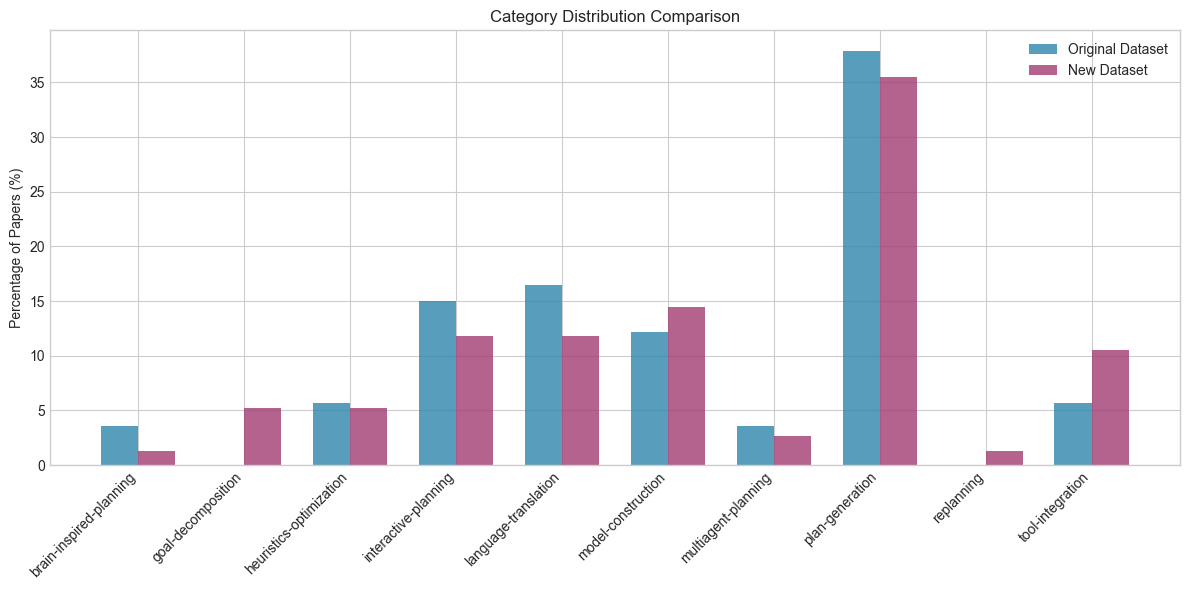

In [10]:
bar_fig = create_side_by_side_barchart(d1, d2)

/var/folders/yc/q_twsl9n5lg8f5977cn3v4jh0000gn/T/ipykernel_72587/2896981503.py:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


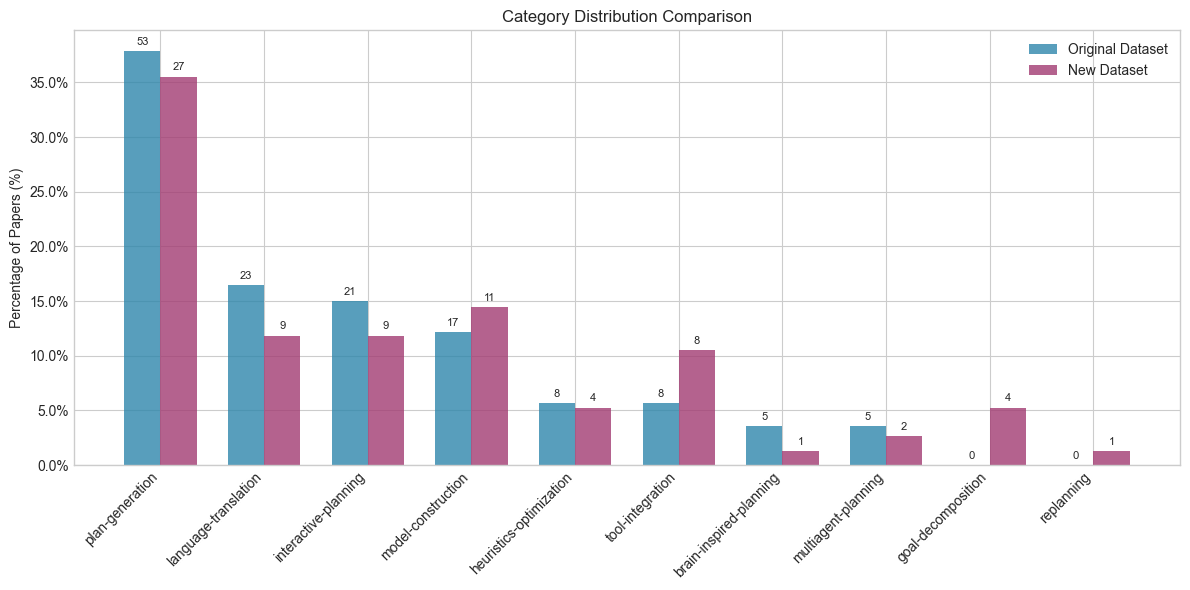

In [11]:
def create_side_by_side_barchart(d1, d2, figsize=(12, 6)):
    # Process data for single category counts
    def get_category_counts(series):
        all_cats = []
        for cats in series.dropna():  # Handle NaN values
            # Convert string representations to lists if necessary
            if isinstance(cats, str):
                cats = eval(cats)
            all_cats.extend(cats)
        return pd.Series(all_cats).value_counts()
    
    # Get counts
    d1_counts = get_category_counts(d1.category)
    d2_counts = get_category_counts(d2.Categories)
    
    # Combine all categories and sort based on d1_counts
    all_categories = list(d1_counts.index)
    # Add any categories from d2 that aren't in d1
    all_categories.extend([cat for cat in d2_counts.index if cat not in all_categories])
    
    # Create DataFrame for plotting
    plot_data = pd.DataFrame({
        'Dataset 1': [d1_counts.get(cat, 0) for cat in all_categories],
        'Dataset 2': [d2_counts.get(cat, 0) for cat in all_categories]
    }, index=all_categories)
    
    # Calculate percentages
    plot_data_pct = plot_data.div(plot_data.sum()) * 100
    
    # Set style
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot
    x = np.arange(len(all_categories))
    width = 0.35
    
    colors = ['#2E86AB', '#A23B72']  # Professional color scheme
    
    # Create bars
    bars1 = ax.bar(x - width/2, plot_data_pct['Dataset 1'], width, 
                   label='Original Dataset', color=colors[0], alpha=0.8)
    bars2 = ax.bar(x + width/2, plot_data_pct['Dataset 2'], width,
                   label='New Dataset', color=colors[1], alpha=0.8)
    
    # Add value annotations
    def autolabel(rects, counts):
        for rect, count in zip(rects, counts):
            height = rect.get_height()
            ax.annotate(f'{count}',
                       xy=(rect.get_x() + rect.get_width()/2, height),
                       xytext=(0, 3),  # 3 points vertical offset
                       textcoords="offset points",
                       ha='center', va='bottom',
                       fontsize=8)
    
    autolabel(bars1, plot_data['Dataset 1'])
    autolabel(bars2, plot_data['Dataset 2'])
    
    # Customize plot
    ax.set_ylabel('Percentage of Papers (%)')
    ax.set_title('Category Distribution Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(all_categories, rotation=45, ha='right')
    ax.legend()
    
    # Add percentage labels to y-axis
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1f}%'.format(y)))
    
    # Adjust layout
    plt.tight_layout()
    return fig

bar_fig = create_side_by_side_barchart(d1, d2)

In [ ]:
bar_fig.savefig("outputs/category_distribution.svg", format='svg', dpi=1200, bbox_inches='tight')

In [ ]:
bar_fig.savefig("outputs/category_distribution.png", format='png', dpi=1200, bbox_inches='tight')